# Model Exploration

In [1]:
import numpy as np
from skneuromsi.sweep import ProcessingStrategyABC

HC_bias_a = np.array(
    [
        -5.21640112246667,
        -4.18706601266667,
        -3.13696911613333,
        -2.09924748133333,
        1.35796414540000,
        3.07563797893333,
        3.81842299133333,
        3.35914483333333,
    ]
)

## TEMPORAL DATA

temporal_dis = (
    np.array(
        [
            -0.7,
            -0.5,
            -0.3,
            -0.25,
            -0.2,
            -0.15,
            -0.1,
            -0.08,
            -0.05,
            -0.02,
            -0.01,
            #    0.0,
            0.01,
            0.02,
            0.05,
            0.08,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.5,
            0.7,
        ]
    )
    * 1000
)

temporal_causes_data = np.array(
    [
        0.03154762,
        0.03214286,
        0.07619048,
        0.19699793,
        0.30345238,
        0.50193093,
        0.72754579,
        0.82582418,
        0.90882784,
        0.93468864,
        0.97271062,
        #    0.97710623,
        0.95398352,
        0.94500916,
        0.94871795,
        0.94787546,
        0.92052078,
        0.87787546,
        0.75857143,
        0.51714286,
        0.33121212,
        0.05779221,
        0.02836439,
    ]
)

HC_pro_com = np.array(
    [
        0.367025484375000,
        0.682562911541667,
        0.822405755208334,
        0.876760716875000,
        0.863113007208333,
        0.809197201583333,
        0.649743997500000,
        0.321256356083333,
    ]
)

temporal_dis_short = np.append(temporal_dis[5:-3:2], temporal_dis[-4])


class CausesProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        causes = result.causes_
        del result._nddata
        return causes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float16)

In [2]:
import matplotlib.pyplot as plt
from skneuromsi.sweep import ParameterSweep
from skneuromsi.bayesian import Kording2007
from skneuromsi.neural import Paredes2022

# MODEL SETUP
model_kording = Kording2007(position_range=(0, 90), position_res=1)
temporal_model_kording = Kording2007(
    time_range=(0, 500), time_res=1, position_range=(0, 1), position_res=1
)

model_paredes = Paredes2022(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 100)
)

causal_model_paredes = Paredes2022(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 150)
)

temporal_model_paredes = Paredes2022(
    neurons=10,
    position_range=(0, 10),
    position_res=1,
    time_range=(0, 700),
    tau=(3.745e01, 1.583e01, 4.112e01),
)

## SWEEP SETUP
dis = np.array([-24, -12, -6, -3, 3, 6, 12, 24])
bias_data = np.abs(HC_bias_a) / np.abs(dis)
causes_data = HC_pro_com

## Auditory Bias

In [3]:
def compute_estimated_position(modes_values):
    max_dim_index = modes_values.index.get_level_values("times").max()
    max_dim_values = modes_values.xs(max_dim_index, level="times").values.T[0]
    estimated_dim_position = max_dim_values.argmax()
    return estimated_dim_position


def compute_bias(estimated_auditory_position, auditory_position, visual_position):
    bias = np.abs(estimated_auditory_position - auditory_position) / np.abs(
        auditory_position - visual_position
    )
    return bias


def compute_bias_from_sweep(sweep_res, a_position=45, v_position=51, mode="auditory"):
    sweep_bias = []
    for res in sweep_res:
        estimated_auditory_position = compute_estimated_position(
            res.get_modes(include=mode)
        )
        bias = compute_bias(
            estimated_auditory_position=estimated_auditory_position,
            auditory_position=a_position,
            visual_position=v_position,
        )
        sweep_bias.append(bias)
    return sweep_bias

Sweeping 'p_common':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'visual_sigma':   0%|          | 0/5 [00:00<?, ?it/s]

/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(.

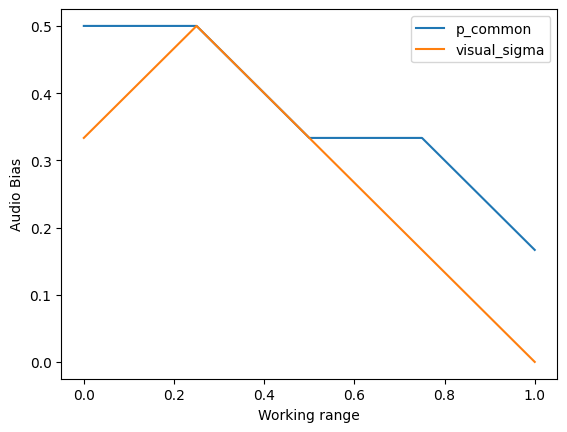

In [4]:
p_common_range = np.linspace(0, 1, 5)
visual_sigma_range = np.linspace(0.125, 6.5, 5)

sp_kording_p_common = ParameterSweep(
    model=model_kording,
    target="p_common",
    repeat=1,
    n_jobs=1,
    range=p_common_range,
)

sp_kording_visual_sigma = ParameterSweep(
    model=model_kording,
    target="visual_sigma",
    repeat=1,
    n_jobs=1,
    range=visual_sigma_range,
)

res_kording_p_common = sp_kording_p_common.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.490e01,
    visual_sigma=2.171e01,
    prior_mu=4.069e01,
    prior_sigma=5.277e00,
    noise=False,
)

res_kording_visual_sigma = sp_kording_visual_sigma.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.490e01,
    prior_mu=4.069e01,
    prior_sigma=5.277e00,
    noise=False,
)

res_kording_p_common_bias = compute_bias_from_sweep(res_kording_p_common)
res_kording_visual_sigma_bias = compute_bias_from_sweep(res_kording_visual_sigma)

plt.plot(p_common_range, res_kording_p_common_bias, label="p_common")
plt.plot(p_common_range, res_kording_visual_sigma_bias, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Audio Bias")
plt.legend()

Sweeping 'lateral_excitation':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'cross_modal_weight':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'feedforward_weight':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'feedback_weight':   0%|          | 0/5 [00:00<?, ?it/s]

/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(.

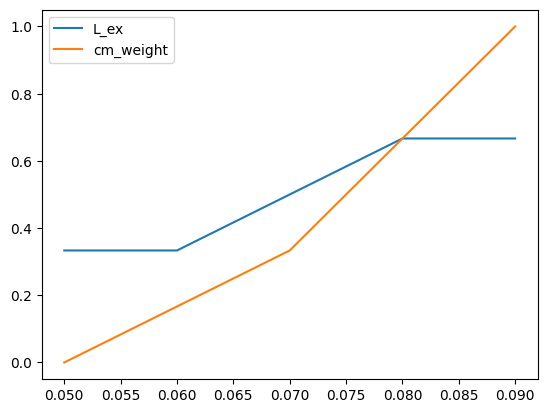

In [5]:
lex_range = np.linspace(0.5, 3, 5)
cm_range = np.linspace(0.05, 0.09, 5)
ff_range = np.linspace(0, 2.5, 5)
fb_range = np.linspace(0, 1, 5)

sp_paredes_lex = ParameterSweep(
    model=model_paredes,
    target="lateral_excitation",
    repeat=1,
    n_jobs=-2,
    range=lex_range,
)

sp_paredes_cm = ParameterSweep(
    model=model_paredes,
    target="cross_modal_weight",
    repeat=1,
    n_jobs=-2,
    range=cm_range,
)

sp_paredes_ff = ParameterSweep(
    model=model_paredes,
    target="feedforward_weight",
    repeat=1,
    n_jobs=-2,
    range=ff_range,
)

sp_paredes_fb = ParameterSweep(
    model=model_paredes,
    target="feedback_weight",
    repeat=1,
    n_jobs=-2,
    range=fb_range,
)

res_paredes_lex = sp_paredes_lex.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_cm = sp_paredes_cm.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_ff = sp_paredes_ff.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_fb = sp_paredes_fb.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_lex_bias = compute_bias_from_sweep(res_paredes_lex)
res_paredes_cm_bias = compute_bias_from_sweep(res_paredes_cm)
# res_paredes_ff_bias = compute_bias_from_sweep(res_paredes_ff)
# res_paredes_fb_bias = compute_bias_from_sweep(res_paredes_fb)

plt.plot(cm_range, res_paredes_lex_bias, label="L_ex")
plt.plot(cm_range, res_paredes_cm_bias, label="cm_weight")
# plt.plot(cm_range, res_paredes_ff_bias, label="ff_weight")
# plt.plot(cm_range, res_paredes_fb_bias, label="fb_weight")
plt.legend()

## Spatial Causal Inference

In [6]:
from scipy.optimize import curve_fit


def gaussian(x, loc, scale, intensity):
    return intensity * np.exp(-(np.square(x - loc)) / (2 * np.square(scale)))


def fit_causes_reports(dis, res_causes, init_scale=1):

    # Create an array representing the x-axis
    x = dis

    # Find the peak value and its position
    peak_idx = np.argmax(res_causes)
    peak_value = res_causes[peak_idx]

    # Estimate initial parameters
    initial_guess = [peak_idx, init_scale, peak_value]

    # Fit the Gaussian function to the data
    params, _ = curve_fit(gaussian, x, res_causes, p0=initial_guess)

    # Extract the mean and standard deviation from the fit parameters
    causes_mean, causes_width, causes_amplitude = params

    return causes_mean, causes_width, causes_amplitude


def sweep_kording_causes_fit(
    causal_sp_kording,
    disparity_range,
    p_common=None,
    v_sigma=None,
    p_common_range=None,
    v_sigma_range=None,
    p_mu=6.898e01,
    p_sigma=4.501e01,
    dim="space",
):
    sweep_causes_fit = []
    par_range = p_common_range if p_common_range is not None else v_sigma_range
    for par in par_range:
        p_common = par if p_common_range is not None else p_common
        v_sigma = par if v_sigma_range is not None else v_sigma
        res_kording_causes = causal_sp_kording.run(
            auditory_position=45,
            auditory_sigma=8.042e00,
            visual_sigma=v_sigma,
            noise=False,
            strategy="selection",
            prior_mu=p_mu,
            prior_sigma=p_sigma,
            causes_kind="prob",
            p_common=p_common,
            dimension=dim,
        )
        sweep_causes_fit.append(fit_causes_reports(disparity_range, res_kording_causes))
    sp_causes_mean, sp_causes_width, sp_causes_amplitude = zip(*sweep_causes_fit)
    return sp_causes_mean, sp_causes_width, sp_causes_amplitude


def sweep_paredes_causes_fit(
    causal_sp_paredes,
    disparity_range,
    lex=2,
    cm=0.075,
    ff=1.4,
    fb=0.10,
    lex_range=None,
    cm_range=None,
    ff_range=None,
    fb_range=None,
):

    if lex_range is not None:
        par_range = lex_range
    elif cm_range is not None:
        par_range = cm_range
    elif ff_range is not None:
        par_range = ff_range
    elif fb_range is not None:
        par_range = fb_range
    else:
        par_range = None

    sweep_causes_fit = []
    for par in par_range:
        lex = par if lex_range is not None else lex
        cm = par if cm_range is not None else cm
        ff = par if ff_range is not None else ff
        fb = par if fb_range is not None else fb
        res_paredes_causes = causal_sp_paredes.run(
            auditory_position=45,
            auditory_sigma=4.215e01,
            visual_sigma=1.673e01,
            auditory_intensity=2.698e01,
            visual_intensity=4.776e00,
            noise=False,
            causes_kind="prob",
            causes_dim="space",
            auditory_soa=None,
            auditory_stim_n=1,
            visual_stim_n=1,
            auditory_duration=100,
            visual_duration=100,
            auditory_onset=0,
            visual_onset=0,
            causes_peak_threshold=0.15,
            lateral_excitation=lex,
            cross_modal_weight=cm,
            feedforward_weight=ff,
            feedback_weight=fb,
        )
        sweep_causes_fit.append(fit_causes_reports(disparity_range, res_paredes_causes))
    sp_causes_mean, sp_causes_width, sp_causes_amplitude = zip(*sweep_causes_fit)
    return sp_causes_mean, sp_causes_width, sp_causes_amplitude

In [7]:
p_common_range = np.linspace(0, 0.9, 5)
visual_sigma_range = np.linspace(4, 12, 5)

causal_sp_kording = ParameterSweep(
    model=model_kording,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
    processing_strategy=CausesProcessingStrategy(),
)

(
    causal_kording_mean_p_common,
    causal_kording_width_p_common,
    causal_kording_amplitude_p_common,
) = sweep_kording_causes_fit(
    causal_sp_kording=causal_sp_kording,
    disparity_range=dis,
    p_common_range=p_common_range,
    v_sigma=8.041e00,
)
(
    causal_kording_mean_v_sigma,
    causal_kording_width_v_sigma,
    causal_kording_amplitude_v_sigma,
) = sweep_kording_causes_fit(
    causal_sp_kording=causal_sp_kording,
    disparity_range=dis,
    v_sigma_range=visual_sigma_range,
    p_common=0.5,
)

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

/home/renato/.virtualenvs/skneuromsi/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

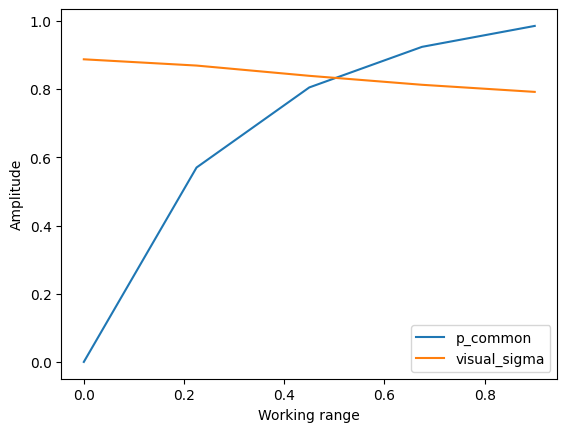

In [8]:
plt.plot(p_common_range, causal_kording_amplitude_p_common, label="p_common")
plt.plot(p_common_range, causal_kording_amplitude_v_sigma, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Amplitude")
plt.legend()

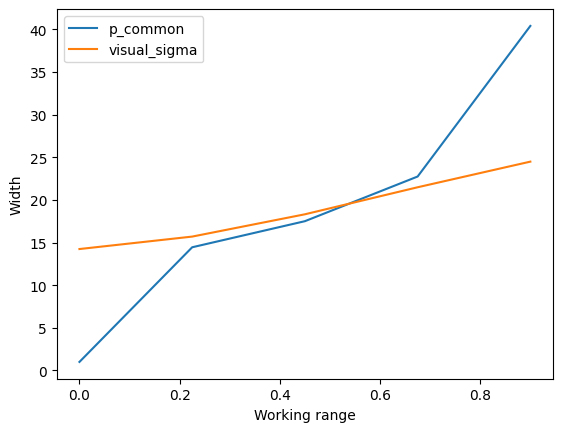

In [9]:
plt.plot(p_common_range, causal_kording_width_p_common, label="p_common")
plt.plot(p_common_range, causal_kording_width_v_sigma, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Width")
plt.legend()

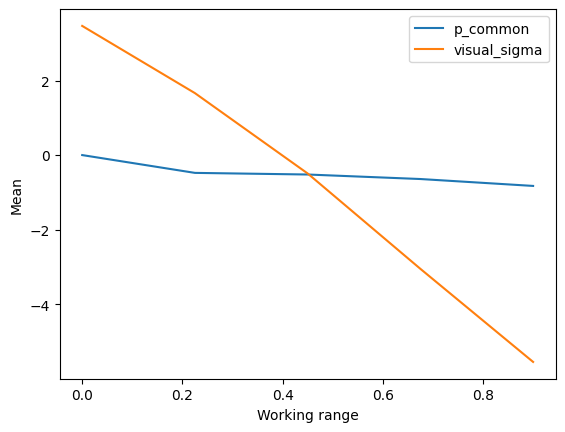

In [10]:
plt.plot(p_common_range, causal_kording_mean_p_common, label="p_common")
plt.plot(p_common_range, causal_kording_mean_v_sigma, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Mean")
plt.legend()

In [11]:
lex_range = np.linspace(1.9, 2, 5)
cm_range = np.linspace(0.0725, 0.08, 5)
ff_range = np.linspace(1.1, 1.4, 5)
fb_range = np.linspace(0, 1, 5)

causal_sp_paredes = ParameterSweep(
    model=causal_model_paredes,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
    processing_strategy=CausesProcessingStrategy(),
)

causal_paredes_mean_lex, causal_paredes_width_lex, causal_paredes_amplitude_lex = (
    sweep_paredes_causes_fit(
        causal_sp_paredes=causal_sp_paredes, disparity_range=dis, lex_range=lex_range
    )
)
causal_paredes_mean_cm, causal_paredes_width_cm, causal_paredes_amplitude_cm = (
    sweep_paredes_causes_fit(
        causal_sp_paredes=causal_sp_paredes, disparity_range=dis, cm_range=cm_range
    )
)
causal_paredes_mean_ff, causal_paredes_width_ff, causal_paredes_amplitude_ff = (
    sweep_paredes_causes_fit(
        causal_sp_paredes=causal_sp_paredes, disparity_range=dis, ff_range=ff_range
    )
)
# causal_paredes_mean_fb, causal_paredes_width_fb, causal_paredes_amplitude_fb = sweep_paredes_causes_fit(causal_sp_paredes=causal_sp_paredes, disparity_range=dis, fb_range=fb_range)

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

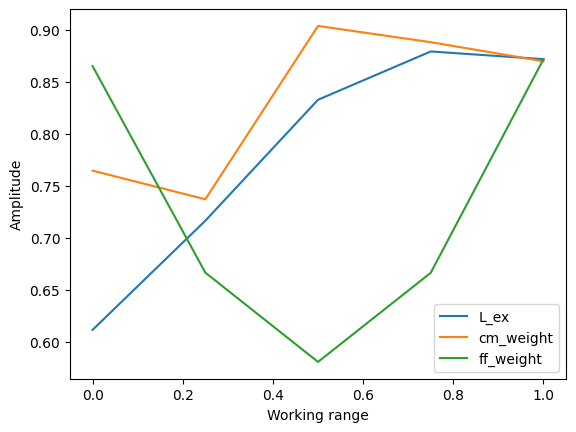

In [12]:
p_common_range = np.linspace(0, 1, 5)

plt.plot(p_common_range, causal_paredes_amplitude_lex, label="L_ex")
plt.plot(p_common_range, causal_paredes_amplitude_cm, label="cm_weight")
plt.plot(p_common_range, causal_paredes_amplitude_ff, label="ff_weight")
# plt.plot(p_common_range, causal_paredes_amplitude_fb, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Amplitude")
plt.legend()

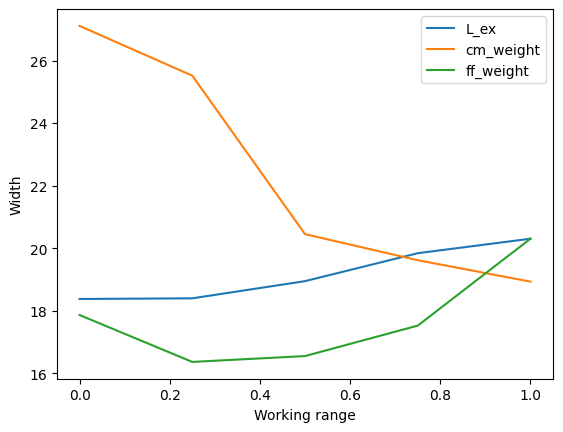

In [13]:
plt.plot(p_common_range, causal_paredes_width_lex, label="L_ex")
plt.plot(p_common_range, causal_paredes_width_cm, label="cm_weight")
plt.plot(p_common_range, causal_paredes_width_ff, label="ff_weight")
# plt.plot(p_common_range, causal_paredes_width_fb, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Width")
plt.legend()

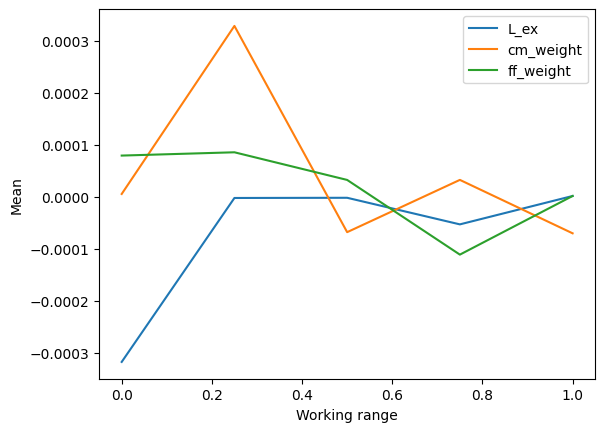

In [14]:
plt.plot(p_common_range, causal_paredes_mean_lex, label="L_ex")
plt.plot(p_common_range, causal_paredes_mean_cm, label="cm_weight")
plt.plot(p_common_range, causal_paredes_mean_ff, label="ff_weight")
# plt.plot(p_common_range, causal_paredes_mean_fb, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Mean")
plt.legend()

## Temporal Causal Inference

In [33]:
def temporal_sweep_kording_causes_fit(
    temporal_causal_sp_kording,
    disparity_range,
    p_common=None,
    a_sigma=None,
    p_common_range=None,
    a_sigma_range=None,
    v_sigma=5.115e01,
    p_mu=1.364e01,
    p_sigma=1.082e02,
    dim="time",
):
    sweep_causes_fit = []
    par_range = p_common_range if p_common_range is not None else a_sigma_range
    for par in par_range:
        p_common = par if p_common_range is not None else p_common
        a_sigma = par if a_sigma_range is not None else a_sigma
        temporal_res_kording_causes = temporal_causal_sp_kording.run(
            visual_position=160,
            auditory_sigma=a_sigma,
            visual_sigma=v_sigma,
            noise=False,
            strategy="selection",
            prior_mu=p_mu,
            prior_sigma=p_sigma,
            causes_kind="prob",
            p_common=p_common,
            dimension=dim,
        )
        sweep_causes_fit.append(
            fit_causes_reports(
                disparity_range, temporal_res_kording_causes, init_scale=10.0
            )
        )
    sp_causes_mean, sp_causes_width, sp_causes_amplitude = zip(*sweep_causes_fit)
    return sp_causes_mean, sp_causes_width, sp_causes_amplitude


def sweep_paredes_temporal_causes_fit(
    temporal_causal_sp_paredes,
    temporal_disparity_range,
    lex=2,
    cm=1.484e-01,
    ff=5.613e00,
    fb=2.210e-03,
    lex_range=None,
    cm_range=None,
    ff_range=None,
    fb_range=None,
):

    if lex_range is not None:
        par_range = lex_range
    elif cm_range is not None:
        par_range = cm_range
    elif ff_range is not None:
        par_range = ff_range
    elif fb_range is not None:
        par_range = fb_range
    else:
        par_range = None

    sweep_causes_fit = []
    for par in par_range:
        lex = par if lex_range is not None else lex
        cm = par if cm_range is not None else cm
        ff = par if ff_range is not None else ff
        fb = par if fb_range is not None else fb
        res_paredes_causes = temporal_causal_sp_paredes.run(
            auditory_intensity=2.55,
            visual_intensity=2.5,
            noise=False,
            causes_kind="prob",
            causes_dim="time",
            auditory_soa=None,
            visual_soa=None,
            auditory_stim_n=1,
            visual_stim_n=1,
            auditory_duration=6,
            visual_duration=6,
            visual_onset=160,
            causes_peak_threshold=0.10,
            causes_peak_distance=1600,
            feed_latency=24,
            lateral_excitation=lex,
            cross_modal_weight=cm,
            feedforward_weight=ff,
            feedback_weight=fb,
        )
        sweep_causes_fit.append(
            fit_causes_reports(
                temporal_disparity_range, res_paredes_causes, init_scale=10.0
            )
        )
    sp_causes_mean, sp_causes_width, sp_causes_amplitude = zip(*sweep_causes_fit)
    return sp_causes_mean, sp_causes_width, sp_causes_amplitude

In [68]:
p_common_range = np.linspace(0.01, 0.9, 5)
auditory_sigma_range = np.linspace(25, 100, 5)

v_onset = 160

temporal_causal_sp_kording = ParameterSweep(
    model=temporal_model_kording,
    target="auditory_position",
    repeat=1,
    n_jobs=-2,
    range=v_onset + temporal_dis_short,
    processing_strategy=CausesProcessingStrategy(),
)

(
    temporal_causal_kording_mean_p_common,
    temporal_causal_kording_width_p_common,
    temporal_causal_kording_amplitude_p_common,
) = temporal_sweep_kording_causes_fit(
    temporal_causal_sp_kording=temporal_causal_sp_kording,
    disparity_range=temporal_dis_short,
    p_common_range=p_common_range,
    a_sigma=5.489e01,
)
(
    temporal_causal_kording_mean_v_sigma,
    temporal_causal_kording_width_v_sigma,
    temporal_causal_kording_amplitude_v_sigma,
) = temporal_sweep_kording_causes_fit(
    temporal_causal_sp_kording=temporal_causal_sp_kording,
    disparity_range=temporal_dis_short,
    a_sigma_range=auditory_sigma_range,
    p_common=0.5,
)

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_position':   0%|          | 0/8 [00:00<?, ?it/s]

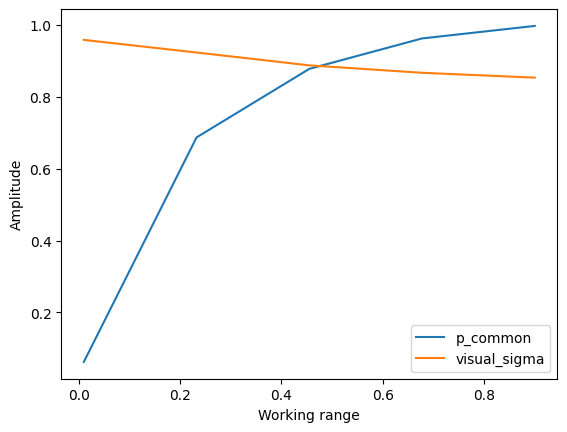

In [69]:
plt.plot(p_common_range, temporal_causal_kording_amplitude_p_common, label="p_common")
plt.plot(
    p_common_range, temporal_causal_kording_amplitude_v_sigma, label="visual_sigma"
)
plt.xlabel("Working range")
plt.ylabel("Amplitude")
plt.legend()

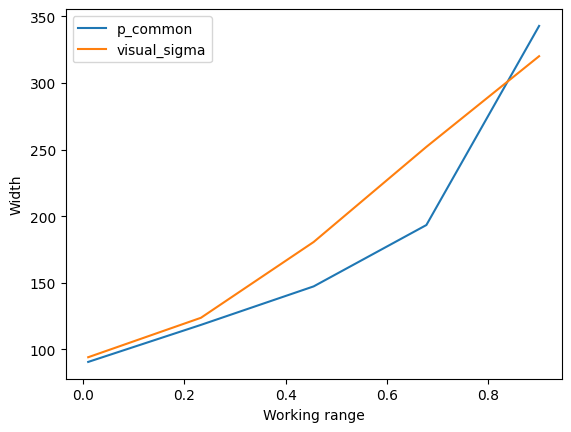

In [70]:
plt.plot(p_common_range, temporal_causal_kording_width_p_common, label="p_common")
plt.plot(p_common_range, temporal_causal_kording_width_v_sigma, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Width")
plt.legend()

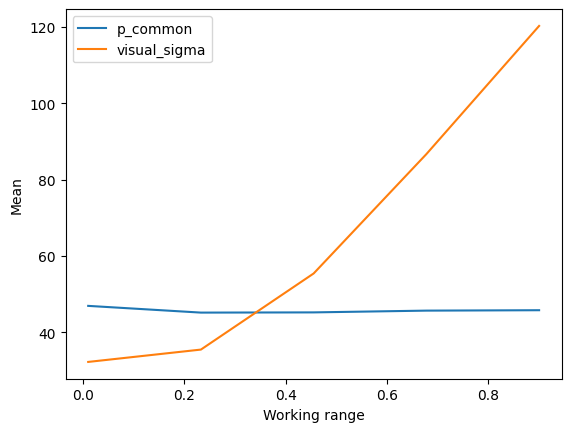

In [71]:
plt.plot(p_common_range, temporal_causal_kording_mean_p_common, label="p_common")
plt.plot(p_common_range, temporal_causal_kording_mean_v_sigma, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Mean")
plt.legend()

In [72]:
lex_range = np.linspace(0.875, 1.5, 5)
cm_range = np.linspace(0.01, 0.20, 5)
ff_range = np.linspace(3.5, 5.4, 5)
fb_range = np.linspace(0.125, 0.5, 5)

temporal_sp_paredes = ParameterSweep(
    model=temporal_model_paredes,
    target="auditory_onset",
    repeat=1,
    n_jobs=-2,
    range=160 + temporal_dis_short,
    processing_strategy=CausesProcessingStrategy(),
)

(
    temporal_causal_paredes_mean_lex,
    temporal_causal_paredes_width_lex,
    temporal_causal_paredes_amplitude_lex,
) = sweep_paredes_temporal_causes_fit(
    temporal_causal_sp_paredes=temporal_sp_paredes,
    temporal_disparity_range=temporal_dis_short,
    lex_range=lex_range,
)
(
    temporal_causal_paredes_mean_cm,
    temporal_causal_paredes_width_cm,
    temporal_causal_paredes_amplitude_cm,
) = sweep_paredes_temporal_causes_fit(
    temporal_causal_sp_paredes=temporal_sp_paredes,
    temporal_disparity_range=temporal_dis_short,
    cm_range=cm_range,
)
(
    temporal_causal_paredes_mean_ff,
    temporal_causal_paredes_width_ff,
    temporal_causal_paredes_amplitude_ff,
) = sweep_paredes_temporal_causes_fit(
    temporal_causal_sp_paredes=temporal_sp_paredes,
    temporal_disparity_range=temporal_dis_short,
    ff_range=ff_range,
)
(
    temporal_causal_paredes_mean_fb,
    temporal_causal_paredes_width_fb,
    temporal_causal_paredes_amplitude_fb,
) = sweep_paredes_temporal_causes_fit(
    temporal_causal_sp_paredes=temporal_sp_paredes,
    temporal_disparity_range=temporal_dis_short,
    fb_range=fb_range,
)

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'auditory_onset':   0%|          | 0/8 [00:00<?, ?it/s]

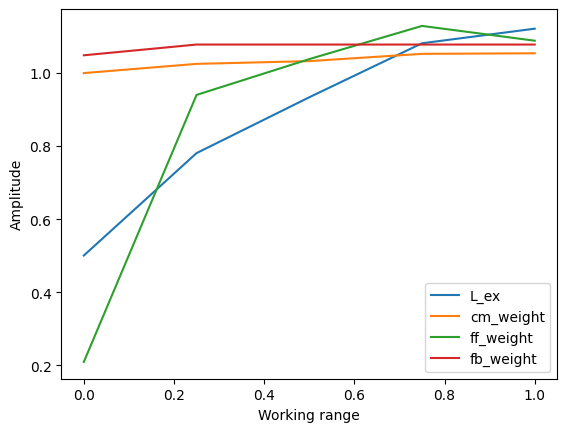

In [73]:
p_common_range = np.linspace(0, 1, 5)

plt.plot(p_common_range, temporal_causal_paredes_amplitude_lex, label="L_ex")
plt.plot(p_common_range, temporal_causal_paredes_amplitude_cm, label="cm_weight")
plt.plot(p_common_range, temporal_causal_paredes_amplitude_ff, label="ff_weight")
plt.plot(p_common_range, temporal_causal_paredes_amplitude_fb, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Amplitude")
plt.legend()

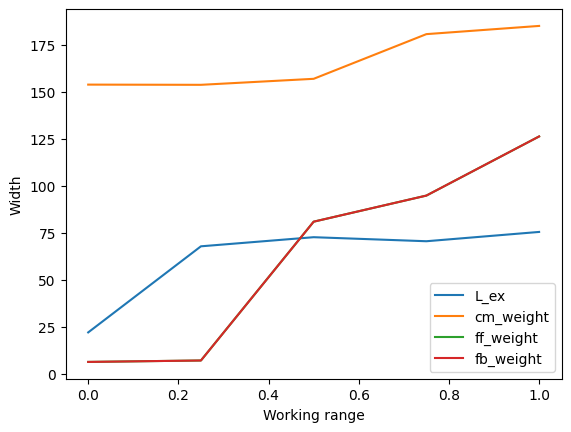

In [74]:
plt.plot(p_common_range, temporal_causal_paredes_width_lex, label="L_ex")
plt.plot(p_common_range, temporal_causal_paredes_width_cm, label="cm_weight")
plt.plot(p_common_range, temporal_causal_paredes_width_ff, label="ff_weight")
plt.plot(p_common_range, temporal_causal_paredes_width_ff, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Width")
plt.legend()

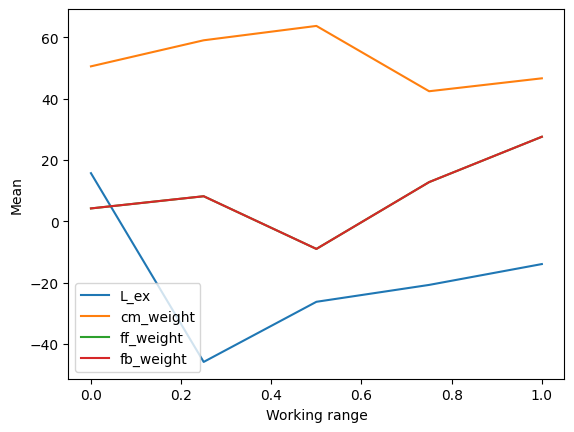

In [75]:
plt.plot(p_common_range, temporal_causal_paredes_mean_lex, label="L_ex")
plt.plot(p_common_range, temporal_causal_paredes_mean_cm, label="cm_weight")
plt.plot(p_common_range, temporal_causal_paredes_mean_ff, label="ff_weight")
plt.plot(p_common_range, temporal_causal_paredes_mean_ff, label="fb_weight")
plt.xlabel("Working range")
plt.ylabel("Mean")
plt.legend()

## Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


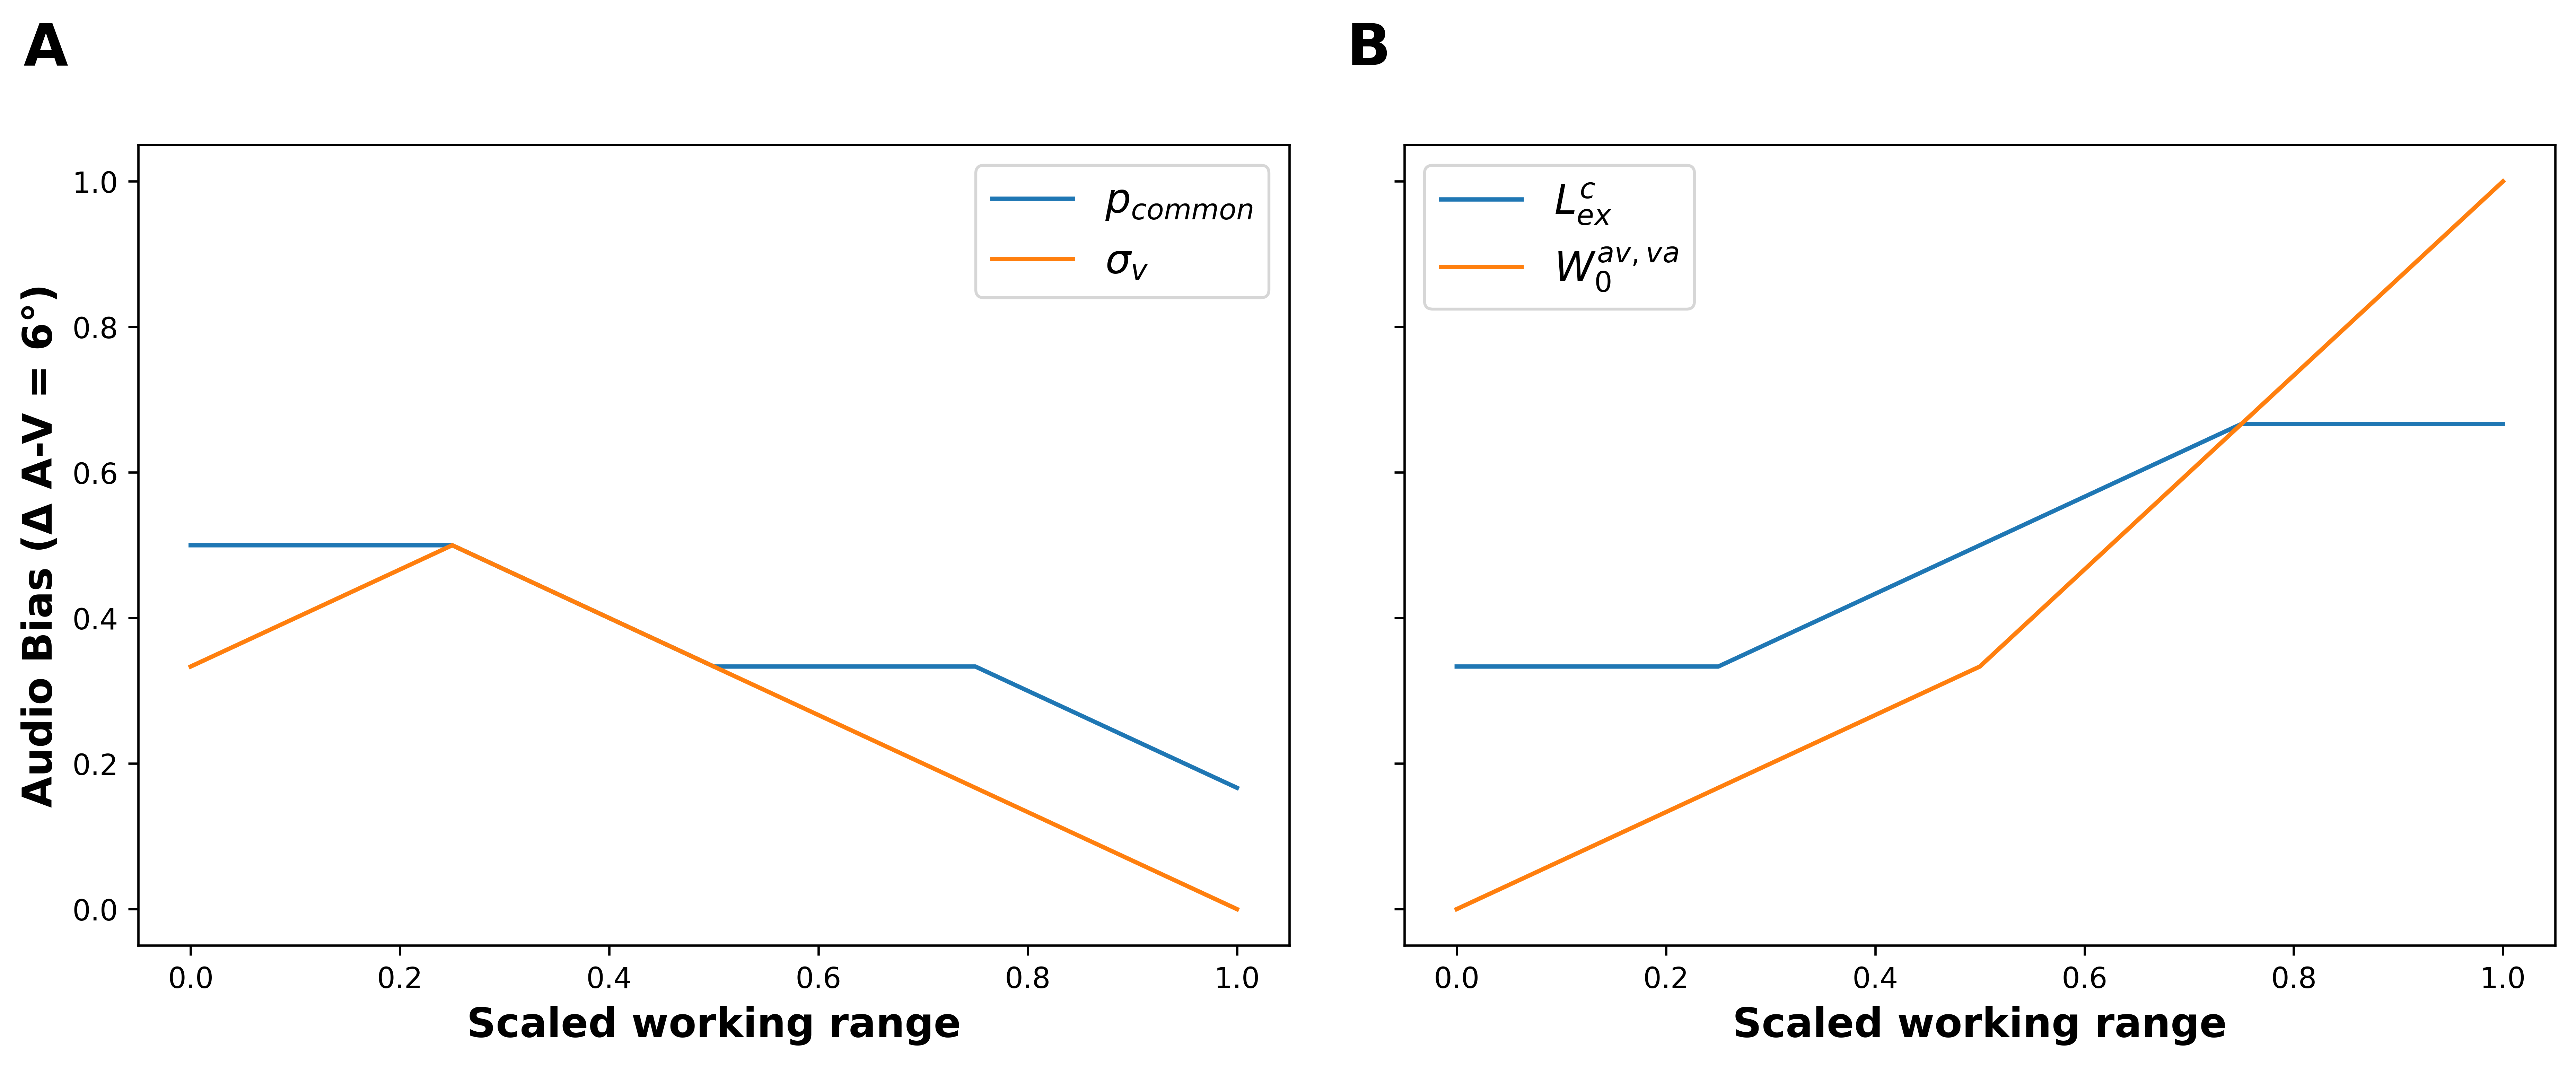

In [81]:
import string

# initializes figure and plots
fig, axs = plt.subplots(
    1,
    2,
    figsize=(15, 5),
    sharex=False,
    sharey=True,
    dpi=600,
    gridspec_kw={"wspace": 0.10},
)
p_common_range = np.linspace(0, 1, 5)

# Panel A
ax1 = plt.subplot(121)
ax1.plot(p_common_range, res_kording_p_common_bias, label="$p_{common}$")
ax1.plot(p_common_range, res_kording_visual_sigma_bias, label="$\sigma_{v}$")
ax1.set_xlabel("Scaled working range", size=14, weight="bold")
ax1.set_ylabel("Audio Bias (Δ A-V = 6°)", size=14, weight="bold")
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)
ax1.legend(fontsize=14)

# Panel B
ax2 = plt.subplot(122)
ax2.plot(p_common_range, res_paredes_lex_bias, label=r"$L_{ex}^{c}$")
ax2.plot(p_common_range, res_paredes_cm_bias, label=r"$W_{0}^{av, va}$")
ax2.set_xlabel("Scaled working range", size=14, weight="bold")
# ax2.set_ylabel("Audio Bias (Δ A-V = 6°)", size=14, weight="bold")
ax2.text(
    -0.05,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)
ax2.legend(fontsize=14)

fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


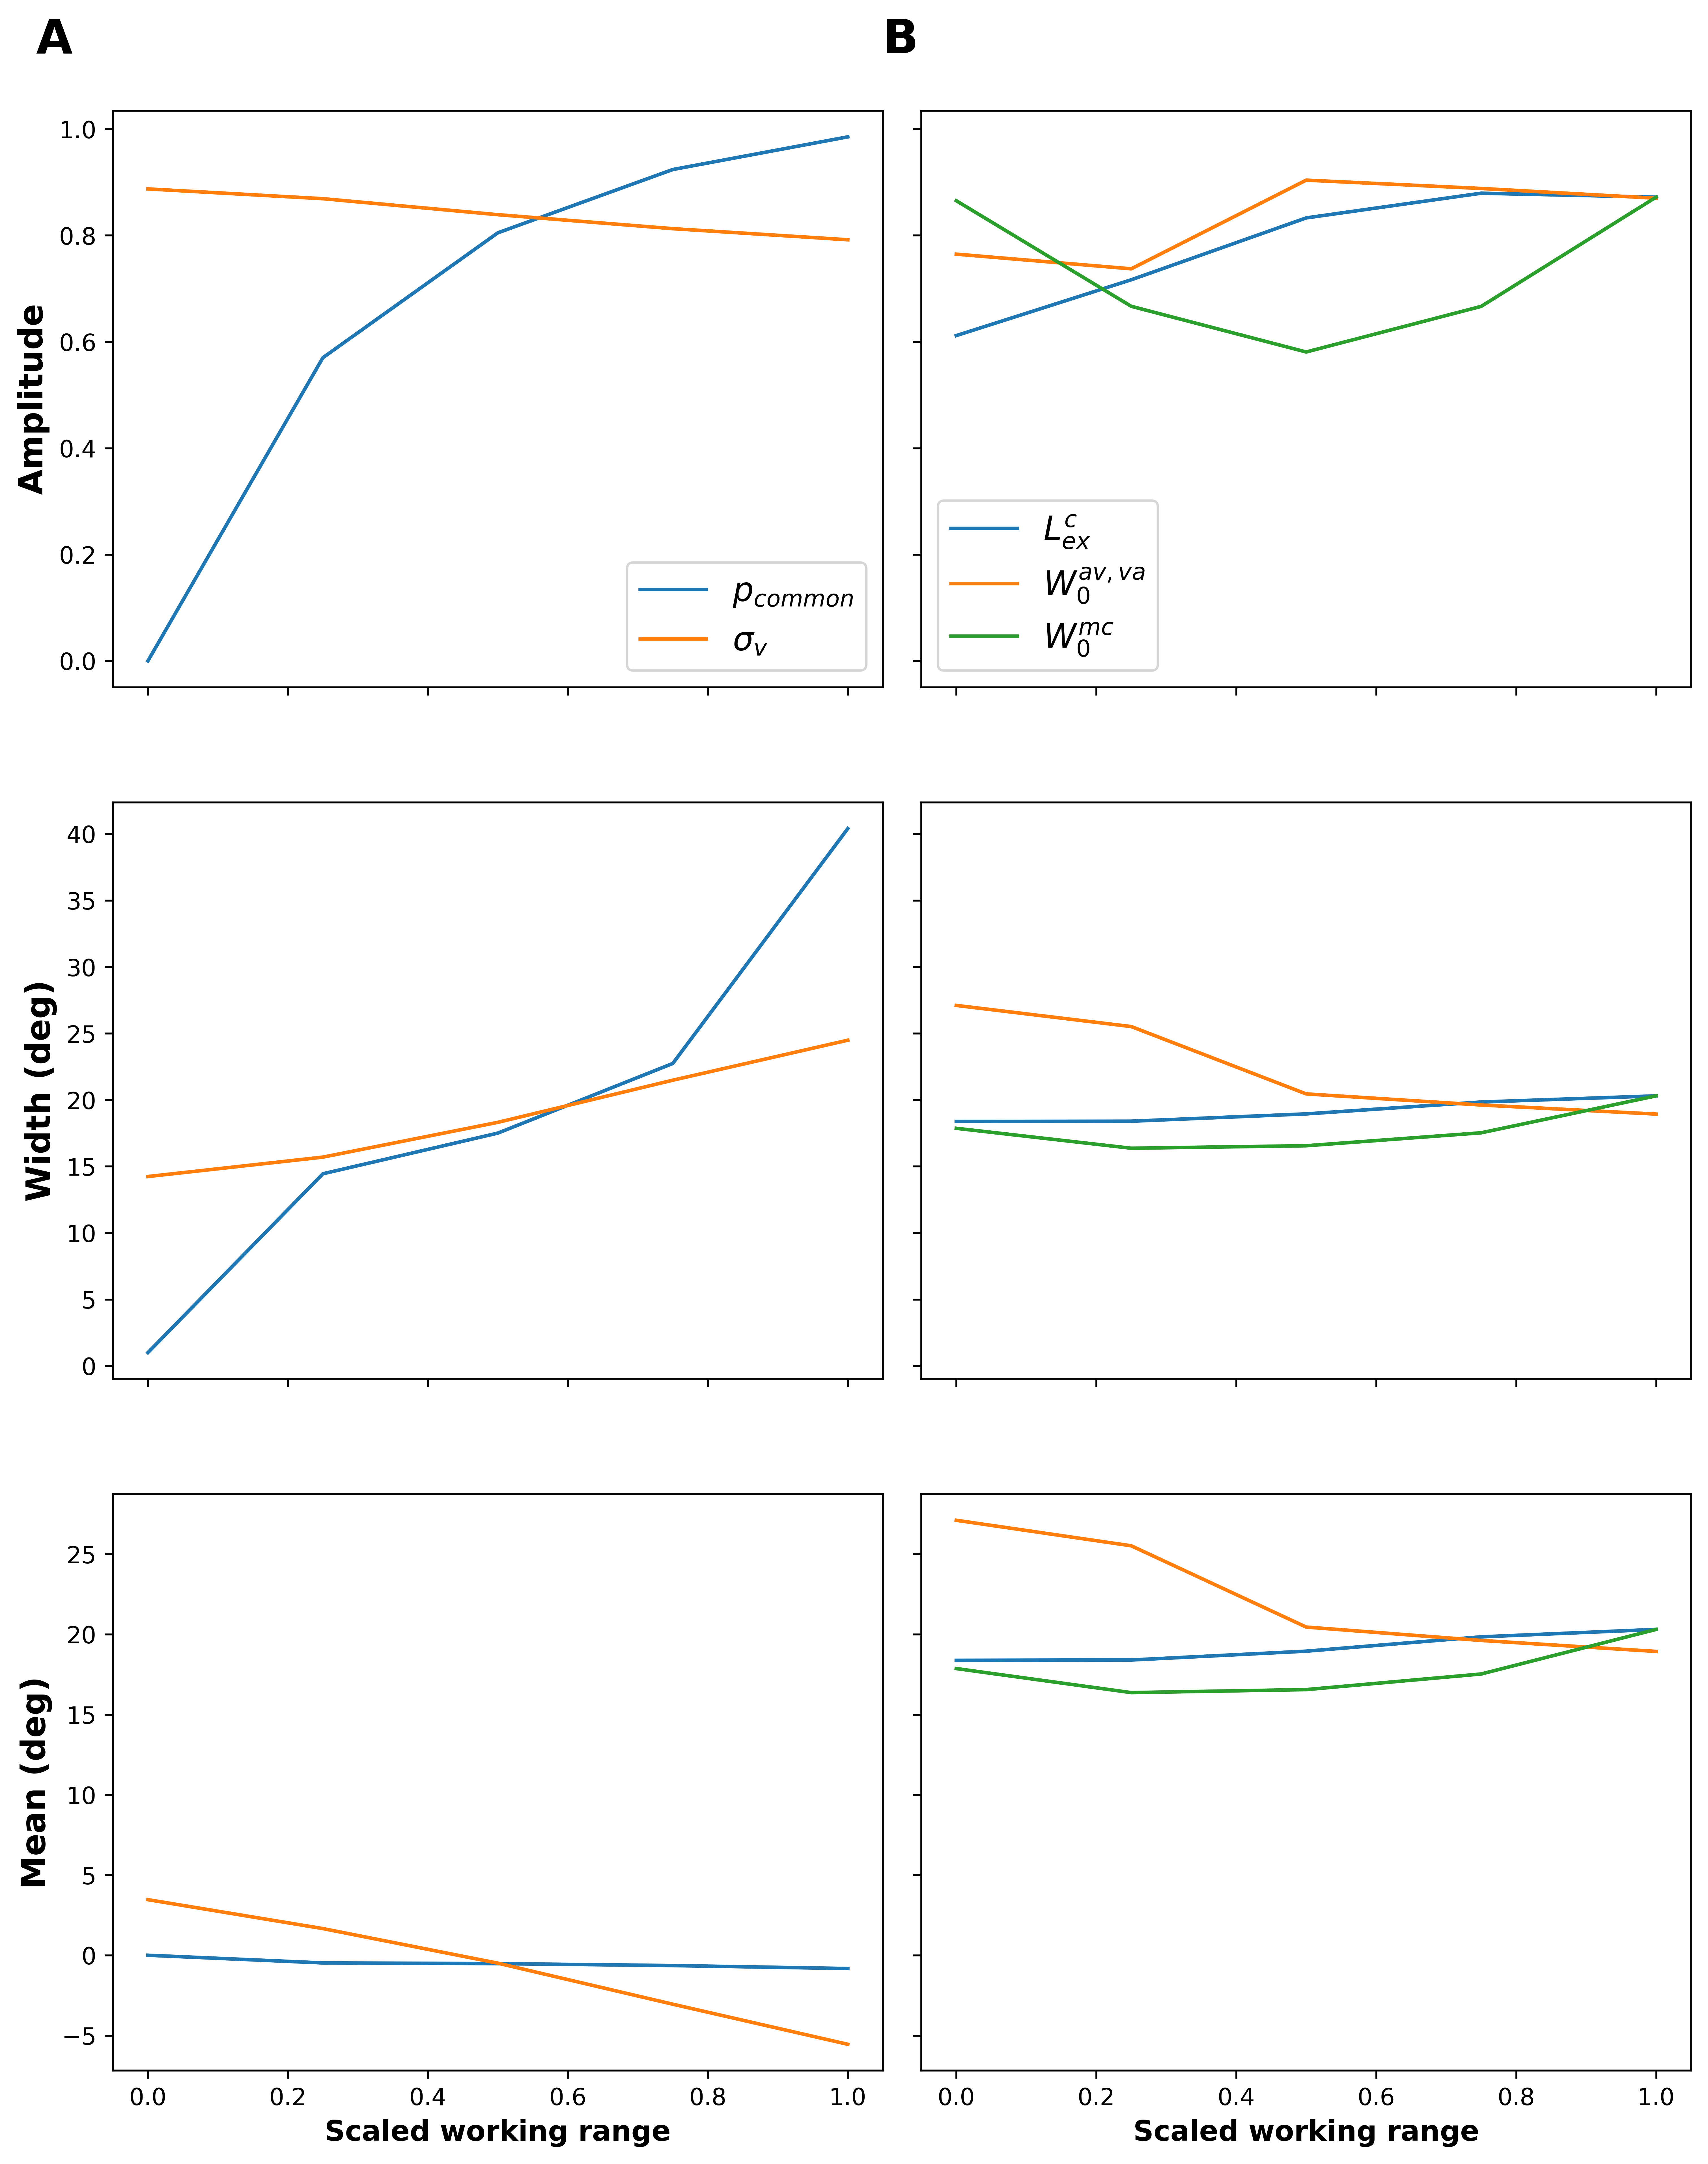

In [80]:
import string

# initializes figure and plots
fig, ax = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 15),
    sharex="all",
    sharey="row",
    dpi=600,
    gridspec_kw={"wspace": 0.05},
)
p_common_range = np.linspace(0, 1, 5)

# Panel A
ax1 = plt.subplot(321)
ax1.plot(p_common_range, causal_kording_amplitude_p_common, label="$p_{common}$")
ax1.plot(p_common_range, causal_kording_amplitude_v_sigma, label="$\sigma_{v}$")
ax1.set_ylabel("Amplitude", size=14, weight="bold")
ax1.legend(fontsize=14)
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax3 = plt.subplot(323)
ax3.plot(p_common_range, causal_kording_width_p_common, label="$p_{common}$")
ax3.plot(p_common_range, causal_kording_width_v_sigma, label="$\sigma_{v}$")
ax3.set_ylabel("Width (deg)", size=14, weight="bold")

ax5 = plt.subplot(325)
ax5.plot(p_common_range, causal_kording_mean_p_common, label="$p_{common}$")
ax5.plot(p_common_range, causal_kording_mean_v_sigma, label="$\sigma_{v}$")
ax5.set_ylabel("Mean (deg)", size=14, weight="bold")
ax5.set_xlabel("Scaled working range", size=12, weight="bold")

# Panel B
ax2 = plt.subplot(322)
ax2.plot(p_common_range, causal_paredes_amplitude_lex, label=r"$L_{ex}^{c}$")
ax2.plot(p_common_range, causal_paredes_amplitude_cm, label=r"$W_{0}^{av, va}$")
ax2.plot(p_common_range, causal_paredes_amplitude_ff, label=r"$W_{0}^{mc}$")
# ax2.set_ylabel("Amplitude", size=12, weight="bold")
ax2.legend(fontsize=14)
ax2.text(
    -0.05,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

ax4 = plt.subplot(324)
ax4.plot(p_common_range, causal_paredes_width_lex, label=r"$L_{ex}^{c}$")
ax4.plot(p_common_range, causal_paredes_width_cm, label=r"$W_{0}^{av, va}$")
ax4.plot(p_common_range, causal_paredes_width_ff, label=r"$W_{0}^{mc}$")
# ax4.set_ylabel("Width", size=12, weight="bold")

ax6 = plt.subplot(326)
ax6.plot(p_common_range, causal_paredes_width_lex, label=r"$L_{ex}^{c}$")
ax6.plot(p_common_range, causal_paredes_width_cm, label=r"$W_{0}^{av, va}$")
ax6.plot(p_common_range, causal_paredes_width_ff, label=r"$W_{0}^{mc}$")
# ax6.set_ylabel("Mean", size=12, weight="bold")
ax6.set_xlabel("Scaled working range", size=12, weight="bold")

fig.savefig("drafts/FIG3.eps", bbox_inches="tight", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


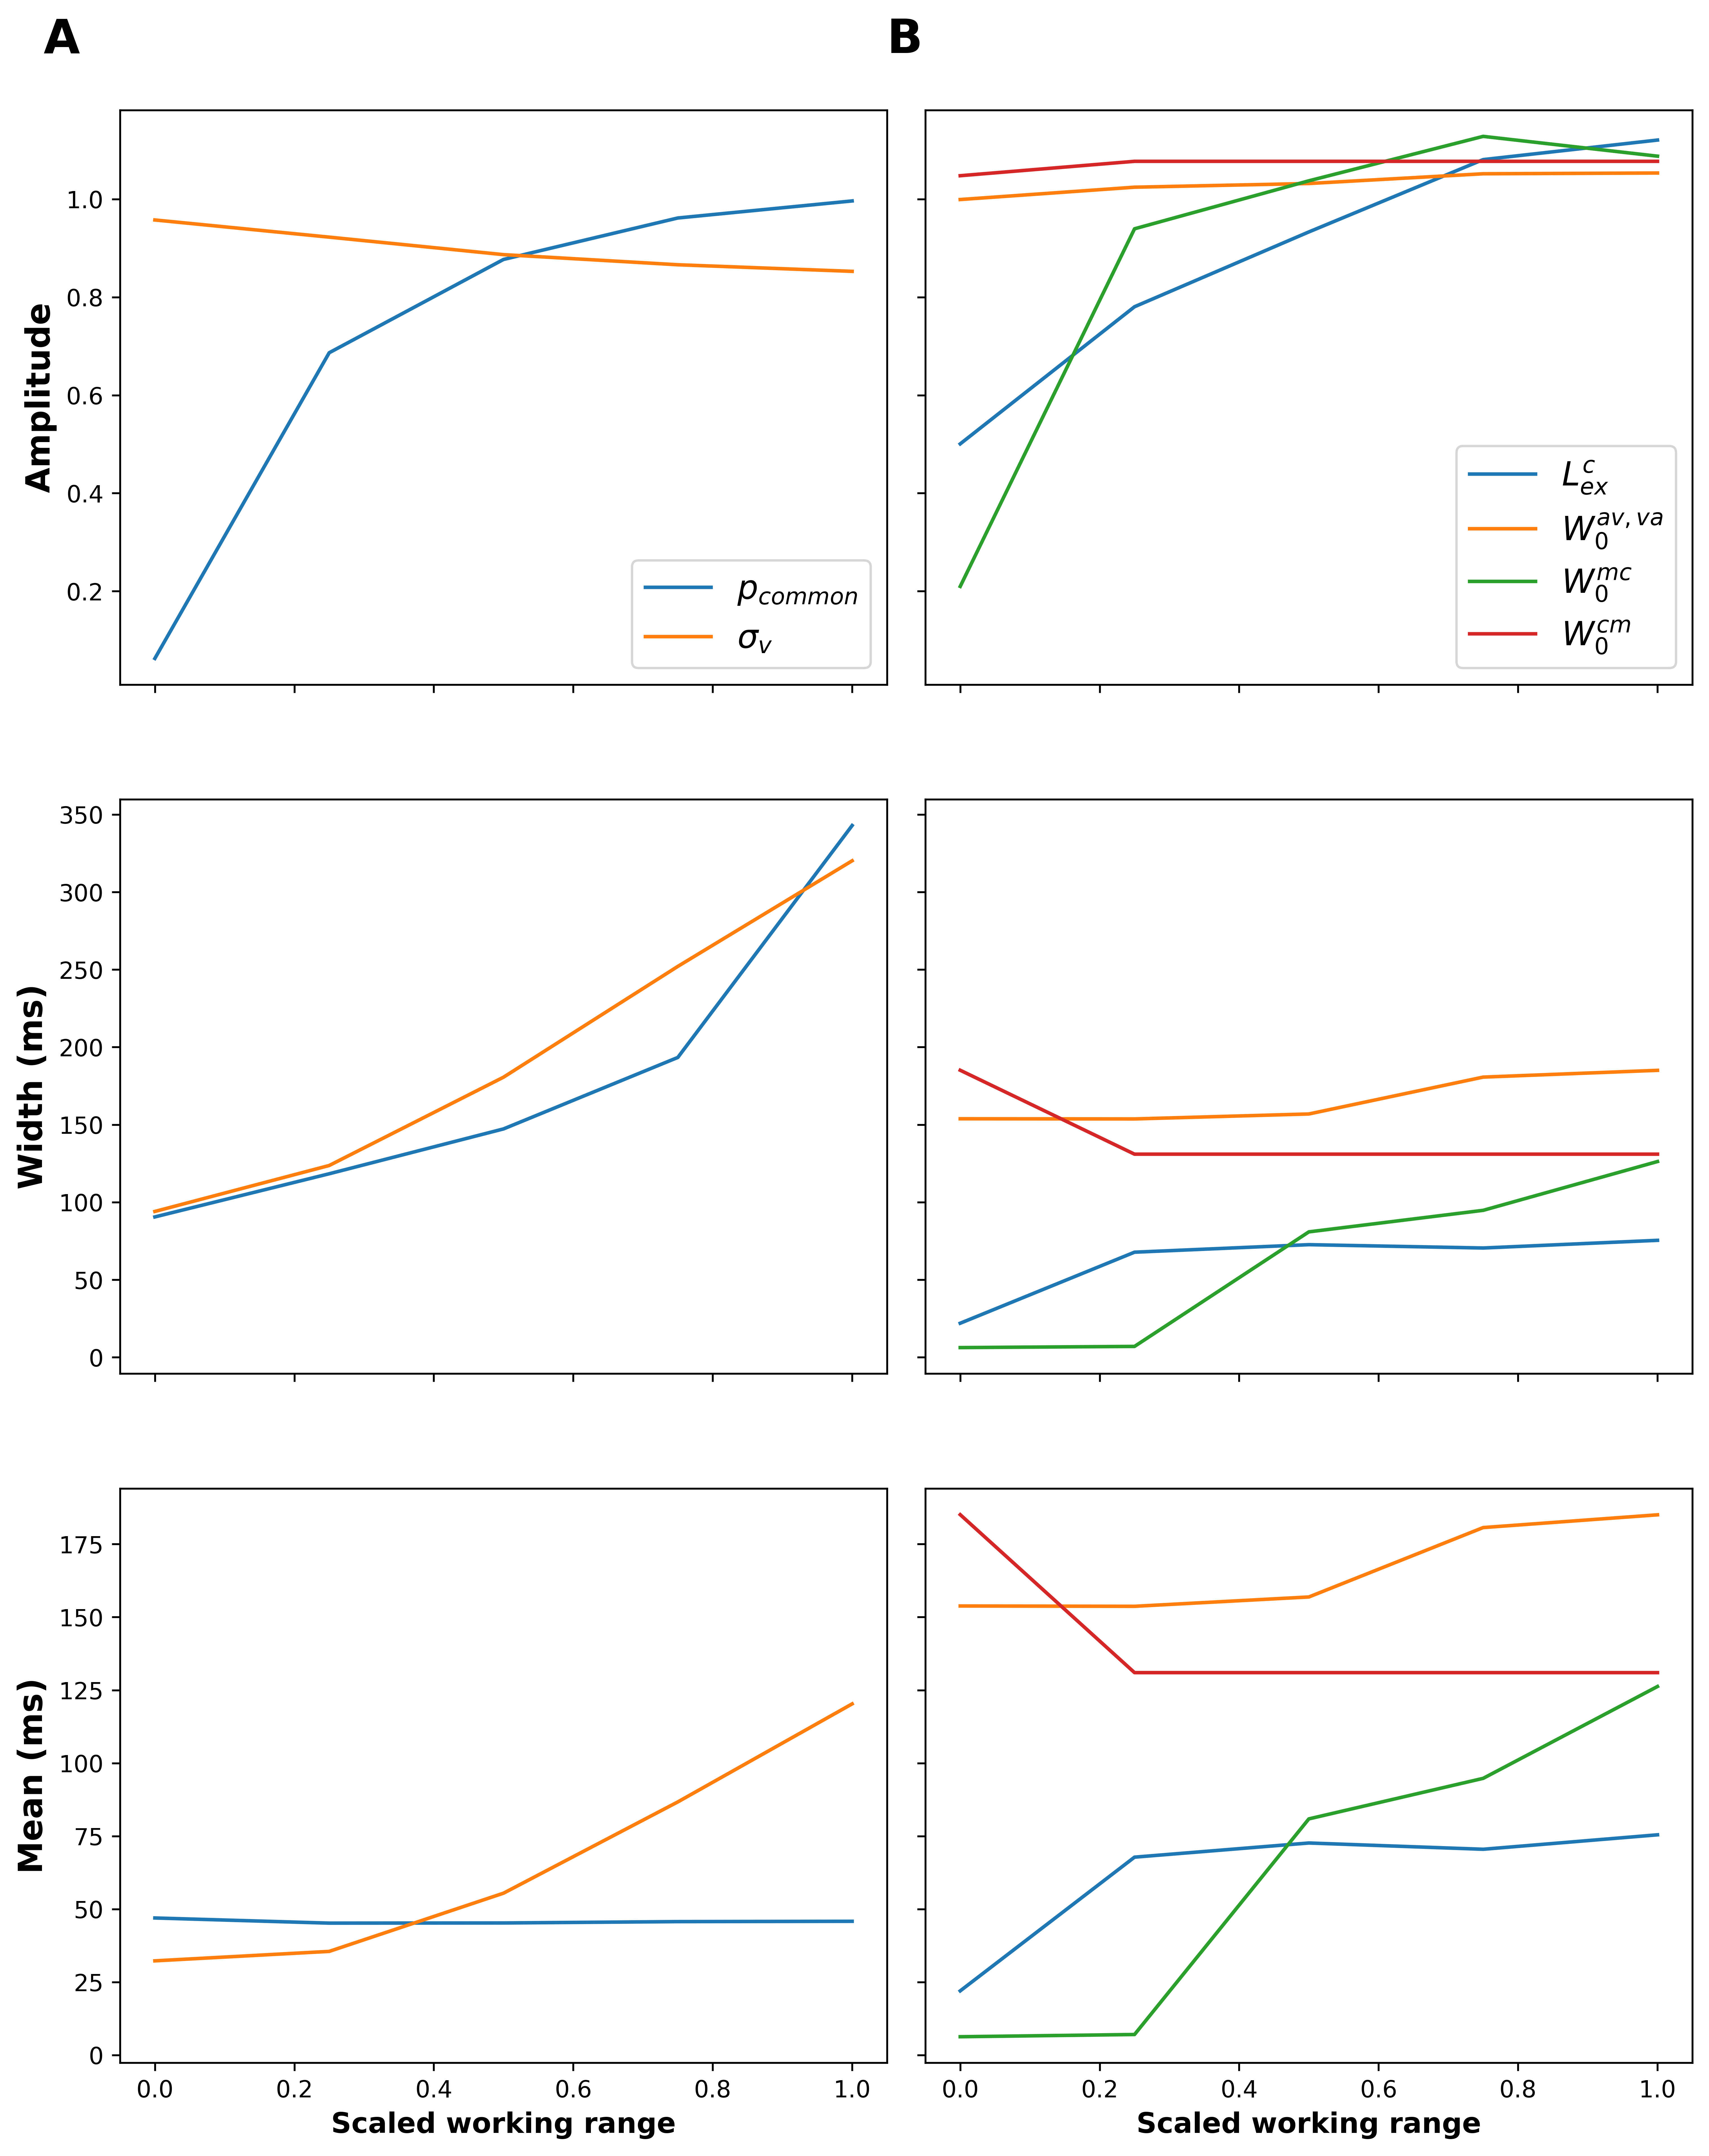

In [79]:
import string

# initializes figure and plots
fig, ax = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 15),
    sharex="all",
    sharey="row",
    dpi=600,
    gridspec_kw={"wspace": 0.05},
)
p_common_range = np.linspace(0, 1, 5)

# Panel A
ax1 = plt.subplot(321)
ax1.plot(
    p_common_range, temporal_causal_kording_amplitude_p_common, label="$p_{common}$"
)
ax1.plot(
    p_common_range, temporal_causal_kording_amplitude_v_sigma, label="$\sigma_{v}$"
)
ax1.set_ylabel("Amplitude", size=14, weight="bold")
ax1.legend(fontsize=14)
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax3 = plt.subplot(323)
ax3.plot(p_common_range, temporal_causal_kording_width_p_common, label="$p_{common}$")
ax3.plot(p_common_range, temporal_causal_kording_width_v_sigma, label="$\sigma_{v}$")
ax3.set_ylabel("Width (ms)", size=14, weight="bold")

ax5 = plt.subplot(325)
ax5.plot(p_common_range, temporal_causal_kording_mean_p_common, label="$p_{common}$")
ax5.plot(p_common_range, temporal_causal_kording_mean_v_sigma, label="$\sigma_{v}$")
ax5.set_ylabel("Mean (ms)", size=14, weight="bold")
ax5.set_xlabel("Scaled working range", size=12, weight="bold")

# Panel B
ax2 = plt.subplot(322)
ax2.plot(p_common_range, temporal_causal_paredes_amplitude_lex, label=r"$L_{ex}^{c}$")
ax2.plot(
    p_common_range, temporal_causal_paredes_amplitude_cm, label=r"$W_{0}^{av, va}$"
)
ax2.plot(p_common_range, temporal_causal_paredes_amplitude_ff, label=r"$W_{0}^{mc}$")
ax2.plot(p_common_range, temporal_causal_paredes_amplitude_fb, label=r"$W_{0}^{cm}$")
# ax2.set_ylabel("Amplitude", size=12, weight="bold")
ax2.legend(fontsize=14)
ax2.text(
    -0.05,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

ax4 = plt.subplot(324)
ax4.plot(p_common_range, temporal_causal_paredes_width_lex, label=r"$L_{ex}^{c}$")
ax4.plot(p_common_range, temporal_causal_paredes_width_cm, label=r"$W_{0}^{av, va}$")
ax4.plot(p_common_range, temporal_causal_paredes_width_ff, label=r"$W_{0}^{mc}$")
ax4.plot(p_common_range, temporal_causal_paredes_width_fb, label=r"$W_{0}^{cm}$")
# ax4.set_ylabel("Width", size=12, weight="bold")

ax6 = plt.subplot(326)
ax6.plot(p_common_range, temporal_causal_paredes_width_lex, label=r"$L_{ex}^{c}$")
ax6.plot(p_common_range, temporal_causal_paredes_width_cm, label=r"$W_{0}^{av, va}$")
ax6.plot(p_common_range, temporal_causal_paredes_width_ff, label=r"$W_{0}^{mc}$")
ax6.plot(p_common_range, temporal_causal_paredes_width_fb, label=r"$W_{0}^{cm}$")
# ax6.set_ylabel("Mean", size=12, weight="bold")
ax6.set_xlabel("Scaled working range", size=12, weight="bold")

fig.savefig("drafts/FIG4.eps", bbox_inches="tight", format="eps")